In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

import xarray as xr

from typing import Sequence, Optional, Union

import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

from collections import namedtuple

import torchsde

#for plotting
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator


from datetime import date
import holidays


from sys import exit

In [96]:
spot_data = pd.read_pickle('spot.pickle')


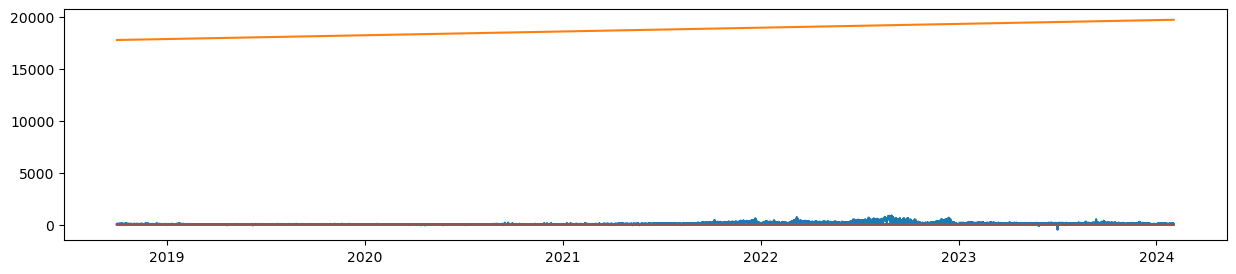

In [97]:
plt.figure(figsize=(15,3))
plt.plot(spot_data)

In [98]:
spot_data['Datetime'] = spot_data.index
spot_data['Day_of_week'] = spot_data['Datetime'].dt.dayofweek # get day of week
spot_data['Month'] = spot_data['Datetime'].dt.month # get hour of day
spot_data['Date'] = spot_data['Datetime'].dt.date
spot_data['Hour_of_day'] = spot_data['Datetime'].dt.hour # get hour of day
de_hldys = holidays.country_holidays('DE')
spot_data['isHoliday?'] = spot_data['Datetime'].apply(lambda x: x in de_hldys) # get holiday or not

In [99]:
print(spot_data)

                            Spot                  Datetime  Day_of_week  \
2018-10-01 00:00:00+00:00  59.53 2018-10-01 00:00:00+00:00            0   
2018-10-01 01:00:00+00:00  56.10 2018-10-01 01:00:00+00:00            0   
2018-10-01 02:00:00+00:00  51.41 2018-10-01 02:00:00+00:00            0   
2018-10-01 03:00:00+00:00  47.38 2018-10-01 03:00:00+00:00            0   
2018-10-01 04:00:00+00:00  47.59 2018-10-01 04:00:00+00:00            0   
...                          ...                       ...          ...   
2024-02-01 20:00:00+00:00  89.97 2024-02-01 20:00:00+00:00            3   
2024-02-01 21:00:00+00:00  83.29 2024-02-01 21:00:00+00:00            3   
2024-02-01 22:00:00+00:00  81.88 2024-02-01 22:00:00+00:00            3   
2024-02-01 23:00:00+00:00  73.38 2024-02-01 23:00:00+00:00            3   
2024-02-02 00:00:00+00:00  64.27 2024-02-02 00:00:00+00:00            4   

                           Hour_of_day  isHoliday?  Month        Date  
2018-10-01 00:00:00+00:00  

In [100]:
print(spot_data[24*85:24*85+2])

                            Spot                  Datetime  Day_of_week  \
2018-12-24 23:00:00+00:00  31.88 2018-12-24 23:00:00+00:00            0   
2018-12-25 00:00:00+00:00  23.79 2018-12-25 00:00:00+00:00            1   

                           Hour_of_day  isHoliday?  Month        Date  
2018-12-24 23:00:00+00:00           23       False     12  2018-12-24  
2018-12-25 00:00:00+00:00            0        True     12  2018-12-25  


In [124]:
spot_data['GWL'] = 0.

In [125]:
print(spot_data.columns)

Index(['Spot', 'Datetime', 'Day_of_week', 'Hour_of_day', 'isHoliday?', 'Month',
       'Date', 'GWL'],
      dtype='object')


In [131]:
GWL = pd.read_excel('GWL.xlsx')

In [132]:
print(GWL)

          Date  value Unnamed: 2 GWL12 Unnamed: 4 GWL24 Unnamed: 6 GWL36  \
0     20181001     15      NWAZT    15      NWAZT     5      NWAAT     5   
1     20181002      5      NWAAT     5      NWAAT     5      NWAAT     5   
2     20181003      5      NWAAT     5      NWAAT     5      NWAAT     4   
3     20181004      5      NWAAT     5      NWAAT     4      SWAAT    24   
4     20181005      4      SWAAT    24      SWZAT    29      SWZAF    29   
...        ...    ...        ...   ...        ...   ...        ...   ...   
1945  20240128      5      NWAAT     4      SWAAT    24      SWZAT     9   
1946  20240129     24      SWZAT     9      SWAAF    29      SWZAF    20   
1947  20240130     29      SWZAF    20      NWAZF     5      NWAAT    10   
1948  20240131      5      NWAAT    10      NWAAF     5      NWAAT    10   
1949  20240201      5      NWAAT    10      NWAAF    10      NWAAF    10   

     Unnamed: 8 GWL48  ... GWL72 Unnamed: 14 GWL96 Unnamed: 16 GWL120  \
0         NWAA

In [133]:
GWL['Date'] = GWL['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [134]:
print(GWL['Date'])

0      2018-10-01
1      2018-10-02
2      2018-10-03
3      2018-10-04
4      2018-10-05
          ...    
1945   2024-01-28
1946   2024-01-29
1947   2024-01-30
1948   2024-01-31
1949   2024-02-01
Name: Date, Length: 1950, dtype: datetime64[ns]


In [143]:
mapping = dict(GWL[['Date', 'value']].values)
spot_data['GWL'] = spot_data['Date'].map(mapping)

In [145]:
print(spot_data.columns)
print(spot_data['GWL'])

Index(['Spot', 'Datetime', 'Day_of_week', 'Hour_of_day', 'isHoliday?', 'Month',
       'Date', 'GWL'],
      dtype='object')
2018-10-01 00:00:00+00:00    2018-10-01
2018-10-01 01:00:00+00:00    2018-10-01
2018-10-01 02:00:00+00:00    2018-10-01
2018-10-01 03:00:00+00:00    2018-10-01
2018-10-01 04:00:00+00:00    2018-10-01
                                ...    
2024-02-01 20:00:00+00:00    2024-02-01
2024-02-01 21:00:00+00:00    2024-02-01
2024-02-01 22:00:00+00:00    2024-02-01
2024-02-01 23:00:00+00:00    2024-02-01
2024-02-02 00:00:00+00:00    2024-02-02
Name: Date, Length: 46802, dtype: object


In [85]:
spot_data.to_pickle('df.pickle')

In [105]:
sel = df[(df['Month'] == 5) & (df['Day_of_week'] == 3)]

In [106]:
print(sel['GWL'])

2019-05-02 00:00:00+00:00   NaN
2019-05-02 01:00:00+00:00   NaN
2019-05-02 02:00:00+00:00   NaN
2019-05-02 03:00:00+00:00   NaN
2019-05-02 04:00:00+00:00   NaN
                             ..
2023-05-25 19:00:00+00:00   NaN
2023-05-25 20:00:00+00:00   NaN
2023-05-25 21:00:00+00:00   NaN
2023-05-25 22:00:00+00:00   NaN
2023-05-25 23:00:00+00:00   NaN
Name: GWL, Length: 504, dtype: float64
